# Pixels to Tabular Data
## Agricultural Statistical Analysis Use Case

Talk about pixels and tabular data.

The use case addressed in this tutorial is:  

* As an agriculture customer, I'd like to create an imagery pipeline that provides for trialing different fungicides by ordering Planet imagery within a single field (AOI), cutting the imagery into multiple field blocks, filtering based on cloud coverage within the blocks, and comparing values across blocks in two ways. First, comparison is performed by extracting median, mean, variance NDVI values for each day (using random point sampling) in each block. Second, comparison is performed by random point selection in each block.


## Introduction

Two things are interesting about this use case. First, we are gridding the AOI into blocks. Second, we are performing some calculations with the output to compare results across different blocks in the field. 


## Implementation

For this use case, the area of interest and time range are not specified. The analytic comparison across blocks means we should specify a strict usable pixel data filter. For time-series analysis the daily coverage of PS satellites is ideal. We are just looking at a field, so we don't need to composite across scenes. This makes our lives easier as we don't need to group the scene ids by date, like we did in Part 2. We are, however, wanting to grid the field. We can use the Orders API to help us with this! And finally, we will need to implement a bit of functionality for the comparisons across the field blocks.

**TODO** UPDATE
To summarize, these are the steps:
1. [Initialize API client](#Step-1:-Initialize-API-client)
1. [Search Data API](#Step-2:-Search-Data-API)
1. [Group IDs by Date](#Step-3:-Group-IDs-by-Date)
1. [Submit Orders](#Step-4:-Submit-Orders)
1. [Download Orders](#Step-5:-Download-Orders)
1. [Unzip and Verify Orders](#Step-6:-Unzip-and-Verify-Orders)



#### Import Dependencies

In [65]:
# from copy import copy
import datetime
import json
import os
from pathlib import Path
from pprint import pprint
import shutil
import time
from zipfile import ZipFile

import numpy as np
from planet import api
from planet.api import downloader, filters
from shapely.geometry import shape

#### Step 1: Initialize API client

In [5]:
# if your Planet API Key is not set as an environment variable, you can paste it below
API_KEY = os.environ.get('PL_API_KEY', 'PASTE_YOUR_KEY_HERE')

client = api.ClientV1(api_key=API_KEY)

#### Step 2: Get Field AOI

In [6]:
# these features come from within the sacramento_crops aoi
# this dataset was prepared in crop-classification/datasets-prepare.ipynb
def load_geojson(filename):
    with open(filename, 'r') as f:
        return json.load(f)
    
fields_filename = os.path.join('pre-data', 'ground-truth-test.geojson')
fields = load_geojson(fields_filename)
field = fields[0]
pprint(field)

{'geometry': {'coordinates': [[[-121.26311573121106, 38.28911976564886],
                               [-121.26309824204209, 38.289263573446426],
                               [-121.26340336500914, 38.28927552343227],
                               [-121.26341580611164, 38.28958419507872],
                               [-121.26335908094813, 38.290060214043095],
                               [-121.2633553819847, 38.29021303818384],
                               [-121.26200888330872, 38.2901989348931],
                               [-121.26202642045222, 38.28924931063856],
                               [-121.26202881277432, 38.28911976564886],
                               [-121.26311573121106, 38.28911976564886]]],
              'type': 'Polygon'},
 'id': '10906',
 'properties': {'ACRES': 5.382,
                'AREA': 21779.33318,
                'BL_X': 651939,
                'BL_Y': 4239347,
                'CLASS1': 'G',
                'CLASS2': '**',
                'CLAS

5.382 acres


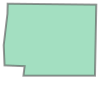

In [7]:
print('{} acres'.format(field['properties']['ACRES']))
field_aoi = field['geometry']
shape(field_aoi)

#### Step 3: Search Data API

The goal of this step is to get the scene ids that meet the search criteria for this use case.

In [16]:
# create an api request from the search specifications
# relax the cloud cover requirement as filtering will be done within the aoi
def build_request(aoi_geom, start_date, stop_date):
    '''build a data api search request for clear PSScene4Band imagery'''
    query = filters.and_filter(
        filters.geom_filter(aoi_geom),
        filters.range_filter('clear_percent', gte=40),
        filters.date_range('acquired', gt=start_date),
        filters.date_range('acquired', lt=stop_date)
    )
    return filters.build_search_request(query, ['PSScene4Band'])

def search_data_api(request, client, limit=500):
    result = client.quick_search(request)
    
    # this returns a generator
    return result.items_iter(limit=limit)

In [17]:
# define test data for the filter
test_start_date = datetime.datetime(year=2019,month=4,day=1)
test_stop_date = datetime.datetime(year=2019,month=5,day=1)

In [18]:
request = build_request(field_aoi, test_start_date, test_stop_date)
print(request)

{'item_types': ['PSScene4Band'], 'filter': {'type': 'AndFilter', 'config': ({'field_name': 'geometry', 'type': 'GeometryFilter', 'config': {'type': 'Polygon', 'coordinates': [[[-121.26311573121106, 38.28911976564886], [-121.26309824204209, 38.289263573446426], [-121.26340336500914, 38.28927552343227], [-121.26341580611164, 38.28958419507872], [-121.26335908094813, 38.290060214043095], [-121.2633553819847, 38.29021303818384], [-121.26200888330872, 38.2901989348931], [-121.26202642045222, 38.28924931063856], [-121.26202881277432, 38.28911976564886], [-121.26311573121106, 38.28911976564886]]]}}, {'field_name': 'clear_percent', 'type': 'RangeFilter', 'config': {'gte': 40}}, {'field_name': 'acquired', 'type': 'DateRangeFilter', 'config': {'gt': '2019-04-01T00:00:00Z'}}, {'field_name': 'acquired', 'type': 'DateRangeFilter', 'config': {'lt': '2019-05-01T00:00:00Z'}})}}


In [19]:
items = list(search_data_api(request, client))
print(len(items))

19


In [20]:
pprint(items[0])

{'_links': {'_self': 'https://api.planet.com/data/v1/item-types/PSScene4Band/items/20190409_185936_13_106c',
            'assets': 'https://api.planet.com/data/v1/item-types/PSScene4Band/items/20190409_185936_13_106c/assets/',
            'thumbnail': 'https://tiles.planet.com/data/v1/item-types/PSScene4Band/items/20190409_185936_13_106c/thumb'},
 '_permissions': ['assets.udm:download',
                  'assets.analytic:download',
                  'assets.analytic_xml:download',
                  'assets.analytic_dn:download',
                  'assets.analytic_dn_xml:download',
                  'assets.basic_analytic:download',
                  'assets.basic_analytic_rpc:download',
                  'assets.basic_analytic_dn:download',
                  'assets.basic_analytic_dn_rpc:download',
                  'assets.basic_analytic_xml:download',
                  'assets.basic_analytic_dn_xml:download',
                  'assets.basic_analytic_dn_nitf:download',
               

In [21]:
for i in items:
    print(i['properties']['epsg_code'])

32610
32610
32610
32610
32610
32610
32610
32610
32610
32610
32610
32610
32610
32610
32610
32610
32610
32610
32610


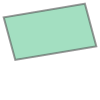

In [22]:
# visualize a footprint
footprints = [shape(i['geometry']) for i in items]
footprints[0]

In [23]:
# make sure all footprints contain the field aoi (that is, no partial overlaps)
for f in footprints:
    assert f.contains(shape(field_aoi))

In [24]:
from shapely.geometry import MultiPolygon

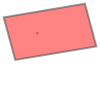

In [35]:
# visualize aoi and footprint
MultiPolygon([shape(field_aoi), footprints[0]])

Whoa look! That AOI is tiny relative to the image footprint. We don't want to wrangle all those pixels outside of the AOI. We definately want to clip the imagery footprints to the AOI.

#### Step 4: Submit Order

Now that we have the scene ids, we can create the order. The output of this step is a single zip file that contains all of the scenes that meet our criteria.

The tools we want to apply are: clip imagery to AOI, convert imagery to NDVI, and reproject all imagery to the same projection. 

##### Step 4.1: Define Toolchain Tools

In this step, we clip the imagery to the AOI and convert the imagery to NDVI.

Why do we clip the imagery to the AOI? As we just saw, the imagery footprints are big, rectangular shapes. They cover the AOI but they do not match the AOI. Since we only care about pixels within the AOI, we clip the footprints to that AOI.

In [44]:
def get_tools(aoi_geom):
    # clip to AOI
    clip_tool = {'clip': {'aoi': aoi_geom}}

    # convert to NDVI
    ndvi_tool = {'bandmath': {
        "pixel_type": "32R",
        "b1": "(b4 - b3) / (b4+b3)"
    }}

    tools = [clip_tool, ndvi_tool]
    return tools

##### Step 4.2: Build Order Requests

In [37]:
def build_order(ids, name, aoi_geom):
    # specify the psscene4band surface reflectance product
    # make sure to get the *_udm2 bundle so you get the udm2 product
    # note: capitalization really matters in item_type when using planet client orders api
    item_type = 'PSScene4Band'
    bundle = 'analytic_sr_udm2'

    orders_request = {
        'name': name,
        'products': [{
            'item_ids': ids,
            'item_type': item_type,
            'product_bundle': bundle
        }],
        'tools': get_tools(aoi_geom),
        'delivery': {
            'single_archive': True,
            'archive_filename':'{{name}}_{{order_id}}.zip',
            'archive_type':'zip'
        },
            'notifications': {
                       'email': False
        },
    }
    return orders_request
# uncomment to see what an order request would look like
# pprint(build_order(['id'], 'demo', test_aoi_geom), indent=4)

In [38]:
ids = [i['id'] for i in items]
name = 'pixels_to_tabular'

In [39]:
order_request = build_order(ids, name, field_aoi)

##### Step 4.2: Submit Order


In [40]:
def create_order(order_request, client):
    orders_info = client.create_order(order_request).get()
    return orders_info['id']

order_id = create_order(order_request, client)
order_id

'5ceb5cf4-2a91-407d-9de9-019c4aced5d1'

#### Step 5: Download Orders

##### Step 5.1: Wait Until Orders are Successful

Before we can download the orders, they have to be prepared on the server.

In [49]:
def poll_for_success(order_id, client, num_loops=50):
    count = 0
    while(count < num_loops):
        count += 1
        order_info = client.get_individual_order(order_id).get()
        state = order_info['state']
        print(state)
        success_states = ['success', 'partial']
        if state == 'failed':
            raise Exception(response)
        elif state in success_states:
            break
        
        time.sleep(10)
        
poll_for_success(order_id, client)

success


##### Step 5.2: Run Download

For this step we will use the planet python orders API because we want to be able to download multiple orders at once, something the CLI does not yet support.

In [53]:
data_dir = os.path.join('data', 'field_statistical_analysis')

# make the download directory if it doesn't exist
Path(data_dir).mkdir(parents=True, exist_ok=True)

In [54]:
!set -x;planet orders download --dest $data_dir $order_id

+ planet orders download --dest data/field_statistical_analysis 5ceb5cf4-2a91-407d-9de9-019c4aced5d1
activating: 0            complete: 0              downloaded: 0.0MB             
downloading: 0           elapsed: 0               paging: False                 
pending: 0                                                                      

activating: 0            complete: 2              downloaded: 0.00MB            
downloading: 0           elapsed: 1               paging: False                 
pending: 0                                                                      

activating: 0            complete: 0              downloaded: 0.0MB             
downloading: 0           elapsed: 2               paging: False                 
pending: 0                                                                      

activating: 0            complete: 0              downloaded: 0.0MB             
downloading: 0           elapsed: 2               paging: False                 
pendi

##### Step 5.3: Get Downloaded File Location(s)
We use the downloaded order manifest to find the downloaded file locations. The manifest is saved in the download directory.

In [57]:
!ls data/field_statistical_analysis

manifest.json  pixels_to_tabular_5ceb5cf4-2a91-407d-9de9-019c4aced5d1.zip


In [59]:
def get_download_locations(download_dir):
    manifest_file = os.path.join(download_dir, 'manifest.json')
    
    with open(manifest_file, 'r') as src:
        manifest = json.load(src)
    
    # uncomment to see the manifest
#     pprint(manifest)
        
    locations = [os.path.join(download_dir, f['path'])
                 for f in manifest['files']]
    return locations

locations = get_download_locations(data_dir)
pprint(locations)

['data/field_statistical_analysis/pixels_to_tabular_5ceb5cf4-2a91-407d-9de9-019c4aced5d1.zip']


#### Step 6: Unzip Order

In this step we will simply unzip the order

##### 6.1: Unzip Order

In this section, we will unzip each order into a directory named after the downloaded zip file.

In [62]:
def unzip(filename, overwrite=False):
    location = Path(filename)
    zipdir = location.parent / location.stem

    if os.path.isdir(zipdir):
        if overwrite:
            print('{} exists. overwriting.'.format(zipdir))
            shutil.rmtree(zipdir)
        else:
            raise Exception('{} already exists'.format(zipdir))
        
    with ZipFile(location) as myzip:
        myzip.extractall(zipdir)
    return zipdir

zipdir = unzip(locations[0])
zipdir

PosixPath('data/field_statistical_analysis/pixels_to_tabular_5ceb5cf4-2a91-407d-9de9-019c4aced5d1')

In [64]:
def get_unzipped_files(zipdir):
    filedir = zipdir / 'files'
    filenames = os.listdir(filedir)
    return [filedir / f for f in filenames]

file_paths = get_unzipped_files(zipdir)

#### Step 7: Filter by Cloudiness